In [1]:
import numpy as np
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random
import math
import os

from torch.autograd import Variable
from IPython.display import clear_output
from matplotlib import collections  as mc

import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
from utils import relation_loader, map_score

# you need to install this package by following command
# pip install treelib
from treelib import Node, Tree


seed = 1
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

- In this exercise, you will derive the Riemannian metric of poincaré ball.
- You will investigate why poincaré ball has advantages for embbeding tree-structured data.

Let $\mathbb{H}^n = \{(x,z)\in\mathbb{R}^{n,1}|z>0, (x^1)^2 + \cdots + (x^n)^2 - z^2 = -1\}$ be a **hyperbolic space** of dimension $n$.\ 

$\mathbb{H}^n$ is a pseudometric space with pseudo metric 
$H = \left[\begin{array}{cc} 
I_{n\times n} & 0\\
0 & -1
\end{array}\right]$\.\
Also, let $\mathbb{B}^n = \{x\in\mathbb{R}^{n}|\| x\| < 1\}$ be the **Poincaré ball**, an $n$-dimensional Riemannian manifold equipped with the Riemannian metric $G(x) = \frac{4}{(1-\|x\|^2)^2}I_{n\times n}$.\



(a) We learned there exists an isometry between $\mathbb{H}^n$ and $\mathbb{B}^n$, which can be visualized as belows if $n=2$.

![Poincare disk for n=2](figures/poincare_disk.png) 

Write the code for the isometric mapping $g: \mathbb{B}^n \rightarrow \mathbb{H}^n$, i.e., design a python function $x\in\mathbb{B}^n \mapsto g(x)\in\mathbb{H}^n$.


(a) Write the code for the isometric mapping from $\mathbb{B}^n$ to $\mathbb{H}^n$.

In [2]:
def B2H(x):
    '''
    A map from B^n to H^n
    x:      torch.tensor whose size = (b, n)
    out:    torch.tensor whose size = (b, n + 1)
    '''
    norm_square = (torch.norm(x, dim = 1) ** 2).unsqueeze(dim=1)
    out = torch.cat([2 * x / (1 - norm_square), (1 + norm_square)/(1 - norm_square)], dim = 1)
    return out

Now, you are going to visualize hyperbolic space by sampling from $\mathbb{B}^2$ and map them to $\mathbb{H}^2$

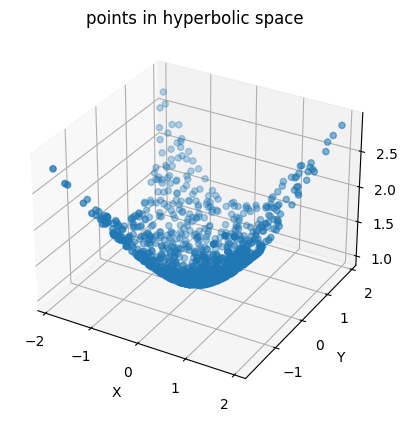

In [3]:
random_points_in_B = torch.rand(1000,2) - 0.5
random_points_in_H = B2H(random_points_in_B)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = random_points_in_H[:,0]
ys = random_points_in_H[:,1]
zs = random_points_in_H[:,2]
ax.scatter(xs, ys, zs)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("points in hyperbolic space")
plt.show()

(b) Assume that the metric of $\mathbb{H}^n$ is given as an arbitrary pseudo metric matrix $H \in \mathbb{R}^{(n+1) \times (n+1)}$. 

Write the code for computing the Riemannian metric of $\mathbb{B}^n$ so that the map B2H (i.e., the map $g$) becomes an isometry.

- Unlike the HW1 where we have used automatic differentiation (e.g. pytorch autograd) to get a Jacobian of a function, you should implement the below function based on the analytic expression of the Jacobian.
- Assume that $H$ is constant.

In [4]:
def get_Riemannian_metric_of_B2H(x, H):
    '''
    x:      torch.tensor whose size = (b, n)
    H:      torch.tensor whose size = (n+1, n+1)
    out:    torch.tensor whose size = (b, n, n)
    '''
    batch_size = x.shape[0]
    dim = x.shape[1]
    norm_x = torch.norm(x, dim=1)
    J1 = 4 * x.unsqueeze(2) * x.unsqueeze(1) / ((1 - norm_x ** 2) ** 2).unsqueeze(1).unsqueeze(2) + \
        2 * torch.eye(dim).unsqueeze(0) / (1 - norm_x ** 2).unsqueeze(1).unsqueeze(2) 
        
    J2 =  (4 * x / (1 - norm_x ** 2).unsqueeze(1) ** 2).unsqueeze(1)
    J = torch.cat([J1, J2], dim=1)
    out = torch.einsum('nij, jk, nkl -> nil', J.permute(0, 2, 1), H, J)
    return out

- Your function "get_Riemannian_metric" should pass the below test code.

In [5]:
H = torch.eye(3)
G = get_Riemannian_metric_of_B2H(random_points_in_B, H)
assert (G.size() == torch.Size([1000, 2, 2]))

rand_v = torch.randn(1000, 2)
assert torch.einsum('ni, nij, nj -> n', rand_v, G, rand_v).min().item() > 0

def G_true(x):
    return torch.eye(2).repeat(x.shape[0], 1, 1) * 4 / (((1 - torch.norm(x, dim=1) ** 2)) ** 2).unsqueeze(-1).unsqueeze(-1)

H[2,2] = -1
G = get_Riemannian_metric_of_B2H(random_points_in_B, H)
assert (torch.norm(G - G_true(random_points_in_B)) < 1e-3)


Visualize equidistant ellipses on $\mathbb{B}^2$ where the Riemannian metric for $\mathbb{B}^2$ is induced from the following two different metrics on $\mathbb{H}^2$:
- $H_1$ : Euclidean metric of $\mathbb{R}^{3}$
- $H_2$ : Riemannian pseudo metric of Hyperbolic space $\mathbb{R}^{2,1}$

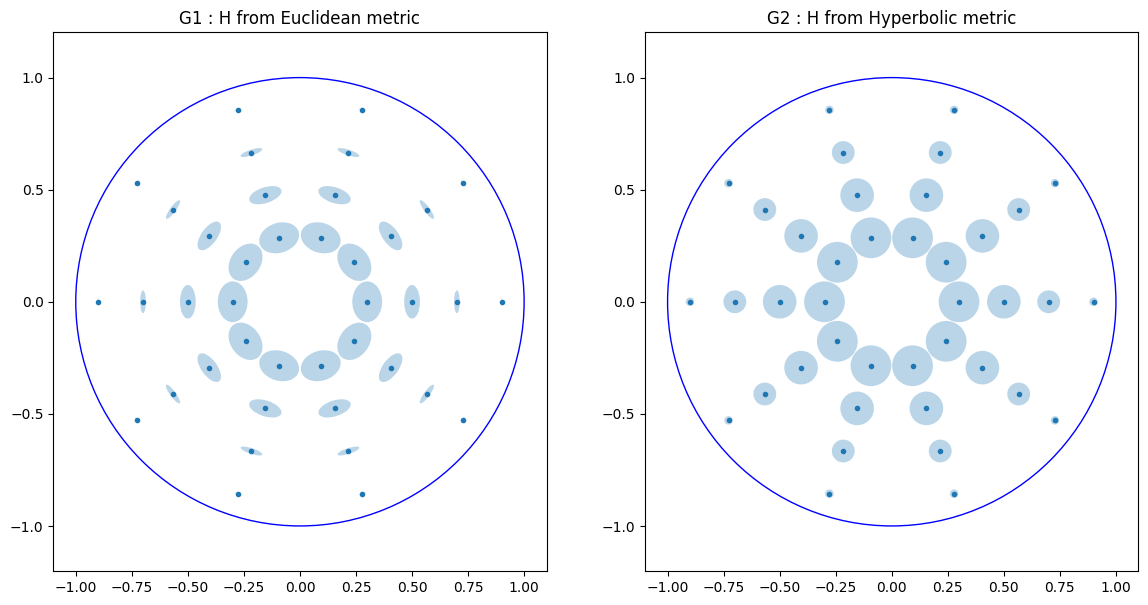

In [6]:
from utils import PD_metric_to_ellipse
# points from B^2
points = []
for i in range(10):
    for j in range(4):
        theta = np.pi * 2 / 10 * i
        radius = 0.3 + 0.2 * j
        points.append([radius * np.cos(theta), radius * np.sin(theta)])
points = torch.Tensor(points)

# get riemannian metric
H1 = torch.eye(3)
H2 = torch.eye(3)
H2[2,2] = -1
G1 = get_Riemannian_metric_of_B2H(points, H1).cpu().numpy()
G2 = get_Riemannian_metric_of_B2H(points, H2).cpu().numpy()

# draw figures
f = plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title("G1 : H from Euclidean metric")
ax = plt.gca()
for i, G in enumerate(G1):
    e = PD_metric_to_ellipse(np.linalg.inv(G), points[i,:], 0.2, alpha = 0.3)
    ax.add_artist(e)
plt.scatter(points.cpu().numpy()[:,0], points.cpu().numpy()[:,1], marker = '.')
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_patch(circle)
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))
plt.axis('equal')

plt.subplot(1,2,2)
plt.title("G2 : H from Hyperbolic metric")
ax = plt.gca()
for i, G in enumerate(G2):
    e = PD_metric_to_ellipse(np.linalg.inv(G), points[i,:], 0.2, alpha = 0.3)
    ax.add_artist(e)

plt.scatter(points.cpu().numpy()[:,0], points.cpu().numpy()[:,1], marker = '.')
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_patch(circle)
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))
plt.axis('equal')
plt.show()

Q1) Can you interpret this result?

(c) Now, let $n=2$. Write down the code which calculates distances between pairs of points in $\mathbb{B}^2$ with the Riemannian metric $\frac{4}{(1-\|x\|^2)^2}I_{2\times 2}$ (which is equivalent to the Riemannian metric induced from $H_2$).
- Use the analytic expression learned in the class (do not numerically solve the geodesic equations).

In [7]:
def dist(u, v, mode):    
    """
    u:      torch.tensor whose size = (b, 2) or (b1, b2, 2)
    v:      torch.tensor whose size = (b, 2) or (b1, b2, 2)
    out:    torch.tensor whose size = (b) or (b1, b2)
    """
    if mode == "Euclidean":
        return torch.norm(u - v, dim = -1)
    if mode == "Riemannian":
        # you may need to use something like eps=1e-6 for numerical stability.
        out = torch.acosh(1 + 1e-6 + 2 * torch.norm(u - v, dim = -1) ** 2 / ((1 - torch.norm(u, dim = -1) ** 2) * (1 - torch.norm(v, dim = -1) ** 2)))
        return out

- Now, you will embed a tree-structured data into the two spaces, $\mathbb{R}^2$ with metric $I_{2\times 2}$ and $\mathbb{B}^2$ with metric $\frac{4}{(1-\|x\|^2)^2}I_{2\times 2}$.
- First, let's generate the tree-structured dataset.
- Note that only connections between parent and child nodes are considered as related.

In [8]:
tree_level_num = 4
tree_branch_num = 4
relations = []
nodes = [[0]]
index = 0
tree = Tree()
tree.create_node("0", "0")
for level in range(tree_level_num):
    parent_nodes = nodes[-1]
    child_nodes = []
    for parent_node in parent_nodes:
        for j in range(1, tree_branch_num + 1):
            index += 1
            child_nodes.append(index)
            tree.create_node(str(index), str(index), parent=str(parent_node))
            relations.append([parent_node, index])
    nodes.append(child_nodes)
tree.show()
nodes_num = sum([len(node_group) for node_group in nodes])

relation_graph = np.zeros([nodes_num, nodes_num])
for relation in relations:
    u = relation[0]
    v = relation[1]
    relation_graph[u, v] = 1
    relation_graph[v, u] = 1

negative_relations = []
for relation in relations:
    u = relation[0]
    v = relation[1]
    N_u = []
    for v_new in range(nodes_num):
        if [u,v_new] not in relations and [v_new,u] not in relations:
            N_u.append([u,v_new])
    for u_new in range(nodes_num):
        if u_new != v:
            if [u_new,v] not in relations and [v,u_new] not in relations:
                N_u.append([u_new,v])
    negative_relations.append(N_u)

colors = []
size = []
for i in range(tree_level_num+1):
    for j in range(len(nodes[i])):
        colors.append(i)
        size.append(10 * (tree_level_num - i + 1) ** 2)

0
├── 1
│   ├── 5
│   │   ├── 21
│   │   │   ├── 85
│   │   │   ├── 86
│   │   │   ├── 87
│   │   │   └── 88
│   │   ├── 22
│   │   │   ├── 89
│   │   │   ├── 90
│   │   │   ├── 91
│   │   │   └── 92
│   │   ├── 23
│   │   │   ├── 93
│   │   │   ├── 94
│   │   │   ├── 95
│   │   │   └── 96
│   │   └── 24
│   │       ├── 100
│   │       ├── 97
│   │       ├── 98
│   │       └── 99
│   ├── 6
│   │   ├── 25
│   │   │   ├── 101
│   │   │   ├── 102
│   │   │   ├── 103
│   │   │   └── 104
│   │   ├── 26
│   │   │   ├── 105
│   │   │   ├── 106
│   │   │   ├── 107
│   │   │   └── 108
│   │   ├── 27
│   │   │   ├── 109
│   │   │   ├── 110
│   │   │   ├── 111
│   │   │   └── 112
│   │   └── 28
│   │       ├── 113
│   │       ├── 114
│   │       ├── 115
│   │       └── 116
│   ├── 7
│   │   ├── 29
│   │   │   ├── 117
│   │   │   ├── 118
│   │   │   ├── 119
│   │   │   └── 120
│   │   ├── 30
│   │   │   ├── 121
│   │   │   ├── 122
│   │   │   ├── 123
│   │   │   └── 124
│   │   ├── 31
│   │   │   

### Opimization on Riemannian manifold
- we will use stochastic gradient descent method in Riemannian manifold.
- SGD update rule for solving $\min_x f(x)$ on Riemannian manifold $M$ with metric $G$ is
    1. $x_{t+1} = x_t - \alpha G^{-1}\frac{\partial f}{\partial x}(x_t)$
    2. $x_{t+1} = \text{proj}_M(x_{t+1})$
- where $\text{proj}_M(x)$ is a projection function from ambient space to $M$.

- The projection function from $\mathbb{R^2}$ to $\mathbb{B^2}$ is as follows:  $\text{proj}_{\mathbb{B^2}}(x) = \frac{x}{\text{max}(\parallel x \parallel, 1-\epsilon)+\epsilon}$

In [9]:
def projection(x, eps=1e-3):
    norm_of_x = torch.norm(x, dim=1)
    new_norm = torch.max(norm_of_x, torch.ones_like(norm_of_x) - eps) + eps
    return x/new_norm.unsqueeze(1)

(d) Write down the code which perform the SGD in Riemannian manifold.

In [10]:
def SGD_update(points, loader, criterion, mode, lr):
    if mode == "Euclidean":
        # copy and modify this code for your code
        points = Variable(points, requires_grad=True)
        pos_pairs, neg_pairs = loader.get_item(points)
        loss = criterion(pos_pairs, neg_pairs, mode) # calculate loss function
        loss.backward() # calculate gradient of the function
        grad = points.grad.data # get gradient value
        points = points.detach()
        points = points - lr * grad.data # gradient descent
        return points
        
    if mode == "Riemannian":
        points = Variable(points, requires_grad=True)
        pos_pairs, neg_pairs = loader.get_item(points)
        loss = criterion(pos_pairs, neg_pairs, mode)
        loss.backward()
        G = get_Riemannian_metric_of_B2H(points, H2)
        grad = torch.einsum('nij,nj->ni', torch.inverse(G), points.grad.data)
        points = points.detach()
        points = points - lr * grad.data
        points = projection(points)
        return points

- The function to be optimized is given as follows.
- This function is motivated from the reference paper (but not exactly the same with that of the paper).

In [11]:
def criterion(pos_pairs, neg_pairs, mode):
    pos = (dist(pos_pairs[:,0,:], pos_pairs[:,1,:], mode))**2 # <- modified. Original ver : dist(pos_pairs[:,0,:], pos_pairs[:,1,:], mode)
    neg = torch.log(torch.sum(torch.exp(-dist(neg_pairs[:,:,0,:], neg_pairs[:,:,1,:], mode)), dim = 1))
    return torch.sum(pos + neg) 

- Now, Embed the dataset on $\mathbb{B}^2$ and save the optimization progress as a gif file named "hyperbolic.gif".

In [12]:
points = np.random.rand(nodes_num, 2) * 0.001
points = Variable(torch.tensor(points, dtype=torch.float32), requires_grad=True)
loader = relation_loader(relations, negative_relations, neg_sample_num=10, batch_num=10)
train_epoch = 1000
lr_init = 0.01
eta = 10.0
mode = "Riemannian"
if not os.path.exists('gif/hyperbolic'):
    os.makedirs('gif/hyperbolic')

In [13]:
for epoch in range(train_epoch):
    if epoch < 10 :
        lr = lr_init / eta
    else : 
        lr = lr_init
    for iter in range(loader.len):
        points = SGD_update(points, loader, criterion, mode, lr)
    if epoch % 10 == 0:
        MAP_score = round(map_score(points, relation_graph, tree_branch_num+1, dist, mode),2)
        f = plt.figure(figsize=(7,7))
        plt.scatter(points.data.cpu().numpy()[:,0], points.data.cpu().numpy()[:,1], marker = '.', s=size, c=colors)
        ax = plt.gca()
        lc = mc.LineCollection(points.data[relations].cpu().numpy(), linewidths=0.5)
        ax.add_collection(lc)
        plt.xlim([-1, 1])
        plt.ylim([-1, 1])
        plt.text(0.55,0.9,"MAP score : " + str(MAP_score))
        plt.savefig(f"gif/hyperbolic/{str(epoch).zfill(4)}.png")
        plt.close()

In [20]:
path = "gif/hyperbolic"
img_list = os.listdir(path)
img_list = [path + '/' + x for x in img_list]
img_list.sort()
images = [Image.open(x) for x in img_list]
im = images[0]
im.save('hyperbolic.gif', save_all=True, append_images=images[1:],loop=0xff, duration=100)

- Embed the dataset on $\mathbb{R}^2$ and save the optimization progress as a gif file named "euclidean.gif".

In [26]:
points = np.random.rand(nodes_num, 2) * 0.001
points = Variable(torch.tensor(points, dtype=torch.float32), requires_grad=True)
loader = relation_loader(relations, negative_relations, neg_sample_num=50, batch_num=10)
train_epoch = 1000
lr = 0.1
mode = "Euclidean"
if not os.path.exists('gif/euclidean'):
    os.makedirs('gif/euclidean')

In [27]:
for epoch in range(train_epoch):
    for iter in range(loader.len):
        points = SGD_update(points, loader, criterion, mode, lr)
    if epoch % 10 == 0:
        MAP_score = round(map_score(points, relation_graph, tree_branch_num+1, dist, mode),2)
        f = plt.figure(figsize=(7,7))
        plt.scatter(points.data.cpu().numpy()[:,0], points.data.cpu().numpy()[:,1], marker = '.', s=size, c=colors)
        ax = plt.gca()
        lc = mc.LineCollection(points.data[relations].cpu().numpy(), linewidths=0.5)
        ax.add_collection(lc)
        plt.xlim([-10, 10])
        plt.ylim([-10, 10])
        plt.text(5.5,9.0,"MAP score : " + str(MAP_score))
        plt.savefig(f"gif/euclidean/{str(epoch).zfill(4)}.png")
        plt.close()

In [28]:
path = "gif/euclidean"
img_list = os.listdir(path)
img_list = [path + '/' + x for x in img_list]
img_list.sort()
images = [Image.open(x) for x in img_list]
im = images[0]
im.save('euclidean.gif', save_all=True, append_images=images[1:],loop=0xff, duration=100)

Q2) Compare the two gif results. Which space looks better for embedding? Which properties do you think make difference?

- Reference paper : ["Poincaré Embeddings for Learning Hierarchical Representations (2017)"](https://arxiv.org/pdf/1705.08039.pdf)